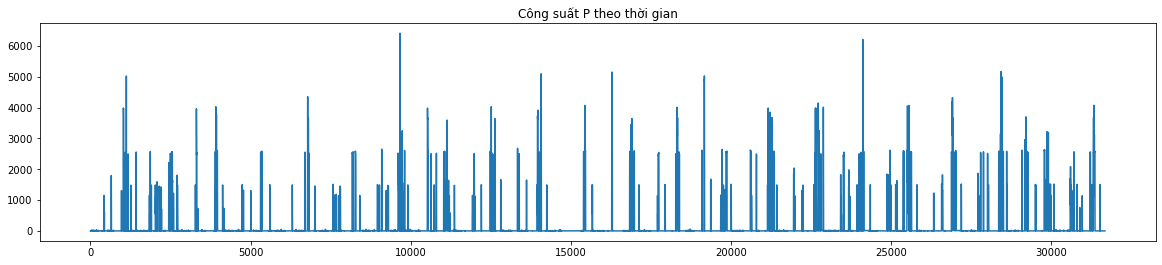

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 4)

# ----------READ DATA-------------
# Power dataframe
p_df = pd.read_csv('./data/W.csv',
                   names=['time', 'light', 'socket', 'heater', 'aircond1', 'aircond2', 'aircond3', 'indcooker'],
                   header=0)
# Voltage dataframe
u_df = pd.read_csv('./data/V.csv',
                   names=['time', 'u'],
                   header=0)
# Current dataframe
i_df = pd.read_csv('./data/A.csv',
                   names=['time', 'light', 'socket', 'heater', 'aircond1', 'aircond2', 'aircond3', 'indcooker'],
                   header=0)
# Power factor dataframe
pf_df = pd.read_csv('./data/cosphi.csv',
                    names=['time', 'light', 'socket', 'heater', 'aircond1', 'aircond2', 'aircond3', 'indcooker'],
                    header=0)

# Reactive power dataframe
q_df = pd.DataFrame()
q_df['time'] = p_df['time']
column_names = ['light', 'socket', 'heater', 'aircond1', 'aircond2', 'aircond3', 'indcooker']

# Calculate reactive power using P and cosphi
for col_name in column_names:
    q_df[col_name] = np.tan(np.arccos(pf_df[col_name])) * p_df[col_name]

select_device = ['heater', 'indcooker']

p_sum = p_df[select_device].sum(axis=1).to_numpy()
q_sum = q_df[select_device].sum(axis=1).to_numpy()
u_sum = u_df['u'].to_numpy()  # không cần tính tổng U, nhưng cứ đặt là u_sum cho đồng nhất
i_sum = i_df[select_device].sum(axis=1).to_numpy() * 100  # Nhân với 100 để I không quá nhỏ

plt.title("Công suất P theo thời gian")
plt.plot(p_sum)
plt.show()

# Prepare data

In [99]:
data = []
label = []
for t in range(0, len(p_sum)):
    data.append([u_sum[t], i_sum[t], p_sum[t], q_sum[t]])
    percent = []
    for j, device_name in enumerate(select_device):
        if p_sum[t] == 0:
            percent.append(0)
        else:
            percent.append(p_df[device_name].iloc[t] / p_sum[t])
    label.append(percent)
        
print("num data point =", len(data))


X = np.array(data)
y = np.array(label)
print(f'{X.shape=}')
print(f'{y.shape=}')
print(f'{X[0:10]=}')
print(f'{y[0:10]=}')

num data point = 31680
X.shape=(31680, 4)
y.shape=(31680, 2)
X[0:10]=array([[231.        ,  25.        ,   1.        ,  49.989999  ],
       [230.        ,  25.        ,   3.5       ,  58.22823866],
       [230.        ,  25.        ,   6.        ,  59.69924623],
       [230.        ,  25.        ,   3.5       ,  58.22823866],
       [230.        ,  25.        ,   1.        ,  49.989999  ],
       [230.        ,  25.        ,   1.        ,  49.989999  ],
       [230.        ,  25.        ,   1.        ,  49.989999  ],
       [230.        ,  25.        ,   4.        ,  57.00268522],
       [230.        ,  25.        ,   5.        ,  58.61064419],
       [230.        ,  25.        ,   2.        ,  57.10784642]])
y[0:10]=array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])


# Implement Multilayer Perceptron 

In [212]:
import numpy as np
from math import exp
from scipy.special import xlogy
from scipy.special import expit as logistic_sigmoid

def sigmoid(x):
    return logistic_sigmoid(x)


def sigmoid_deriv(x):
    sm = sigmoid(x)
    return sm * (1 - sm)


def relu(x):
    return np.maximum(0, x)


def relu_deriv(x):
    ret = np.copy(x)
    ret[ret > 0] = 1
    ret[ret <= 0] = 0
    return ret


def tanh(x):
    return np.tanh(x)


def tanh_deriv(x):
    return 1 - np.exp2(tanh(x))

def identity(x):
    return x

def identity_deriv(x):
    return np.ones(x.shape)

def binary_log_loss(y_true, y_prob):
    eps = np.finfo(y_prob.dtype).eps
    y_prob = np.clip(y_prob, eps, 1 - eps)
    return -(xlogy(y_true, y_prob).sum() +
             xlogy(1 - y_true, 1 - y_prob).sum()) / y_prob.shape[0]

def mse_loss(y_true, y_prob):
    return ((y_true - y_prob) ** 2).sum() / y_prob.shape[0] / 2

class MyMLPRegressor():
    def __init__(self, 
                 hidden_layer_sizes=(30,), 
                 learning_rate=0.001,
                 max_iter=100,
                 random_state=0,
                 tol=0.001,
                 n_iter_no_change=100,
                 beta_1=0.9,
                 beta_2=0.999,
                 epsilon=1e-8,
                 hidden_activation='relu',
                 output_activation='identity'):
        if hidden_activation == 'relu':
            self.hidden_activation_func = relu
            self.hidden_activation_deriv = relu_deriv
        elif hidden_activation == 'tanh':
            self.hidden_activation_func = tanh
            self.hidden_activation_deriv = tanh_deriv
        elif hidden_activation == 'sigmoid':
            self.hidden_activation_func = sigmoid
            self.hidden_activation_deriv = sigmoid_deriv
        else:
            raise AttributeErrorr("Hidden activation function must be in ['relu', 'sigmoid', 'tanh']")
        
        if output_activation == 'sigmoid':            
            self.output_activation_func = sigmoid
            self.output_activation_deriv = sigmoid_deriv
        elif output_activation == 'identity':
            self.output_activation_func = identity
            self.output_activation_deriv = identity_deriv
        else:
            raise AttributeErro("Output activation function must be 'sigmoid' or'identity'")
        self.hidden_layer_sizes = hidden_layer_sizes
        self.learning_rate=learning_rate
        self.max_iter=max_iter
        self.tol = tol
        self.n_iter_no_change = n_iter_no_change
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        np.random.seed(random_state)
        
        
    def fit(self, X, y):
        n_sample, n_feature = X.shape
        hidden_layer_sizes = list(self.hidden_layer_sizes)
        
        n_input_unit = n_feature
        n_output_unit = y.shape[1]
        layer_units = [n_input_unit] + hidden_layer_sizes + [n_output_unit]
        self.n_layers_ = len(layer_units)
        
        # Weight and bias initialization
        W = [None] * self.n_layers_
        b = [None] * self.n_layers_
        for i in range(1, self.n_layers_):
            factor = 6
            init_bound = np.sqrt(factor / (layer_units[i-1] + layer_units[i]))
            W[i] = np.random.uniform(-init_bound, init_bound, 
                                   (layer_units[i], layer_units[i-1]))
            b[i] = np.random.uniform(-init_bound, init_bound,
                                  (layer_units[i], 1))



        
        # Adam algorithm variables
        VdW = [None] * self.n_layers_
        SdW = [None] * self.n_layers_
        Vdb = [None] * self.n_layers_
        Sdb = [None] * self.n_layers_
        for i in range(1, self.n_layers_):
            VdW[i] = np.zeros((layer_units[i], layer_units[i-1]))
            SdW[i] = np.zeros((layer_units[i], layer_units[i-1]))
            Vdb[i] = np.zeros((layer_units[i], 1))
            Sdb[i] = np.zeros((layer_units[i], 1))
        
        it = 0
        self.loss_ = []
        while True:
            it += 1
            if it > self.max_iter:
                print(f"Reach {self.max_iter} epochs. Stopping.")
                
            A = [X.T] + [None] * (self.n_layers_ - 1)
            Z = [None] * (self.n_layers_)

            # forward pass
            for i in range(1, self.n_layers_):
                Z[i] = np.dot(W[i], A[i-1]) + b[i]
                if i != self.n_layers_ - 1:
                    A[i] = self.hidden_activation_func(Z[i])
                else:
                    A[i] = self.output_activation_func(Z[i])

            # compute MSE loss
            loss = mse_loss(y, A[-1].T)
            print(f'iteration={it} {loss=}')
            self.loss_.append(loss)
            
            if it > self.n_iter_no_change:
                if self.loss_[-self.n_iter_no_change] - self.loss_[-1] < self.tol:
                    print(f'Training loss did not improve more than {self.tol=} for {self.n_iter_no_change} consecutive epochs. Stopping.')
                    break
                    
            # backpropagation
            dA = [None] * self.n_layers_
            dZ = [None] * self.n_layers_
            dW = [None] * self.n_layers_
            db = [None] * self.n_layers_
            for i in range(self.n_layers_ - 1, 0, -1):
                if i == self.n_layers_ - 1:
                    dA[i] = A[-1] - y.T
                    dZ[i] = np.multiply(dA[i], self.output_activation_deriv(Z[i]))
                else:
                    dA[i] = np.dot(W[i+1].T, dZ[i+1])
                    dZ[i] = np.multiply(dA[i], self.hidden_activation_deriv(Z[i]))
                dW[i] = np.dot(dZ[i], A[i-1].T) / n_sample
                db[i] = np.sum(dZ[i], axis=1, keepdims=True) / n_sample

            # adam optimization algorithm
            for i in range(1, self.n_layers_):
                VdW[i] = self.beta_1 * VdW[i] + (1 - self.beta_1) * dW[i]
                Vdb[i] = self.beta_1 * Vdb[i] + (1 - self.beta_1) * db[i]
                SdW[i] = self.beta_2 * SdW[i] + (1 - self.beta_2) * (dW[i] ** 2)
                Sdb[i] = self.beta_2 * Sdb[i] + (1 - self.beta_2) * (db[i] ** 2)
            
            # correct the first loops
            if it < 20:
                for i in range(1, self.n_layers_):
                    VdW[i] = VdW[i] / (1 - self.beta_1 ** it)
                    Vdb[i] = Vdb[i] / (1 - self.beta_1 ** it)
                    SdW[i] = SdW[i] / (1 - self.beta_2 ** it)
                    Sdb[i] = Sdb[i] / (1 - self.beta_2 ** it)
            
            # update params
            for i in range(1, self.n_layers_):
                W[i] = W[i] - self.learning_rate * VdW[i] / (np.sqrt(SdW[i]) + self.epsilon)
                b[i] = b[i] - self.learning_rate * Vdb[i] / (np.sqrt(Sdb[i]) + self.epsilon)
            

        self.W_ = W
        self.b_ = b
        
    def predict(self, X):
        W = self.W_
        b = self.b_
        
        Z = [None] * self.n_layers_
        A = [X.T] + [None] * (self.n_layers_ - 1)
        for i in range(1, self.n_layers_):
            Z[i] = np.dot(W[i], A[i-1]) + b[i]
            if i != self.n_layers_ - 1:
                A[i] = self.hidden_activation_func(Z[i])
            else:
                A[i] = self.output_activation_func(Z[i])
                
        return A[-1].T
    
    def score(self, X_test, y_test):
        y_pred = self.predict(X_test)
        u = ((y_test - y_pred) ** 2).sum()
        v = ((y_test - y_test.mean()) ** 2).sum()
        return 1 - u / v

# Test

Data:
https://www.itl.nist.gov/div898/strd/nls/nls_main.shtml
https://www.itl.nist.gov/div898/strd/nls/data/thurber.shtml

In [239]:
y = np.array([8.06E+01, 8.42E+01, 8.73E+01, 8.72E+01, 8.91E+01, 8.96E+01, 8.99E+01, 9.01E+01, 9.24E+01, 9.59E+01, 1.01E+02, 1.01E+02, 4.02E+02, 3.91E+02, 5.68E+02, 6.35E+02, 7.33E+02, 7.59E+02, 8.94E+02, 9.91E+02, 1.09E+03, 1.08E+03, 1.12E+03, 1.18E+03, 1.26E+03, 1.27E+03, 1.29E+03, 1.33E+03, 1.35E+03, 1.41E+03, 1.43E+03, 1.42E+03, 1.44E+03, 1.46E+03, 1.47E+03, 1.45E+03, 1.46E+03])
X = np.array([-3.07E+00, -2.98E+00, -2.92E+00, -2.91E+00, -2.84E+00, -2.80E+00, -2.70E+00, -2.70E+00, -2.63E+00, -2.48E+00, -2.36E+00, -2.32E+00, -1.50E+00, -1.46E+00, -1.27E+00, -1.21E+00, -1.10E+00, -1.05E+00, -9.15E-01, -7.14E-01, -5.66E-01, -5.45E-01, -4.00E-01, -3.09E-01, -1.09E-01, -1.03E-01, 1.00E-02, 1.19E-01, 3.77E-01, 7.90E-01, 9.63E-01, 1.01E+00, 1.12E+00, 1.57E+00, 1.84E+00, 2.05E+00, 2.20E+00])

In [252]:
# https://www.itl.nist.gov/div898/strd/nls/data/gauss1.shtml
X = np.arange(250)
y = np.array([97.62227, 97.80724, 96.62247, 92.59022, 91.23869, 95.32704, 90.3504, 89.46235, 91.7252, 89.86916, 86.88076, 85.9436, 87.60686, 86.25839, 80.74976, 83.03551, 88.25837, 82.01316, 82.74098, 83.30034, 81.2785, 81.85506, 80.75195, 80.09573, 81.07633, 78.81542, 78.38596, 79.93386, 79.48474, 79.95942, 76.10691, 78.3983, 81.4306, 82.48867, 81.65462, 80.84323, 88.68663, 84.74438, 86.83934, 85.97739, 91.28509, 97.22411, 93.51733, 94.10159, 101.9176, 98.43134, 110.4214, 107.6628, 111.7288, 116.5115, 120.7609, 123.9553, 124.2437, 130.7996, 133.296, 130.7788, 132.0565, 138.6584, 142.9252, 142.7215, 144.1249, 147.4377, 148.2647, 152.0519, 147.3863, 149.2074, 148.9537, 144.5876, 148.1226, 148.0144, 143.8893, 140.9088, 143.4434, 139.3938, 135.9878, 136.3927, 126.7262, 124.4487, 122.8647, 113.8557, 113.7037, 106.8407, 107.0034, 102.4629, 96.09296, 94.57555, 86.98824, 84.90154, 81.18023, 76.40117, 67.092, 72.67155, 68.10848, 67.99088, 63.34094, 60.55253, 56.18687, 53.64482, 53.70307, 48.07893, 42.21258, 45.65181, 41.69728, 41.24946, 39.21349, 37.71696, 36.68395, 37.30393, 37.43277, 37.45012, 32.64648, 31.84347, 31.39951, 26.68912, 32.25323, 27.61008, 33.58649, 28.10714, 30.26428, 28.01648, 29.11021, 23.02099, 25.65091, 28.50295, 25.23701, 26.13828, 33.5326, 29.25195, 27.09847, 26.52999, 25.52401, 26.69218, 24.55269, 27.71763, 25.20297, 25.61483, 25.06893, 27.6393, 24.94851, 25.86806, 22.48183, 26.90045, 25.39919, 17.90614, 23.76039, 25.89689, 27.64231, 22.86101, 26.47003, 23.72888, 27.54334, 30.52683, 28.07261, 34.92815, 28.29194, 34.19161, 35.41207, 37.09336, 40.9833, 39.53923, 47.80123, 47.46305, 51.04166, 54.58065, 57.53001, 61.42089, 62.79032, 68.51455, 70.23053, 74.42776, 76.59911, 81.62053, 83.42208, 79.17451, 88.56985, 85.66525, 86.55502, 90.65907, 84.2729, 85.7222, 83.10702, 82.16884, 80.42568, 78.15692, 79.79691, 77.84378, 74.50327, 71.57289, 65.88031, 65.01385, 60.19582, 59.66726, 52.95478, 53.87792, 44.91274, 41.09909, 41.68018, 34.53379, 34.86419, 33.14787, 29.58864, 27.29462, 21.91439, 19.08159, 24.9029, 19.82341, 16.75551, 18.24558, 17.23549, 16.34934, 13.71285, 14.75676, 13.97169, 12.42867, 14.35519, 7.703309, 10.23441, 11.78315, 13.87768, 4.5357, 10.05928, 8.424824, 10.53312, 9.602255, 7.877514, 6.258121, 8.899865, 7.877754, 12.51191, 10.66205, 6.0354, 6.790655, 8.783535, 4.600288, 8.400915, 7.216561, 10.01741, 7.331278, 6.527863, 2.842001, 10.32507, 4.790995, 8.377101, 6.264445, 2.706213, 8.362329, 8.983658, 3.362571, 1.182746, 4.875359])


## No use sklearn

In [264]:
X = X.reshape((-1, 1))
y = y.reshape((-1, 1))
model = MyMLPRegressor(
                    hidden_layer_sizes=(20,),
                    learning_rate=2,
                    random_state=1,
                    max_iter=100000,
                    n_iter_no_change=200,
                    tol=0.001,
                    hidden_activation='relu',
                    output_activation='identity')


model.fit(X, y)
model.score(X, y)

iteration=1 loss=3594.2807998018648
iteration=2 loss=3564078.058909035
iteration=3 loss=29202.587479322403
iteration=4 loss=3731.6809915196513
iteration=5 loss=2715.710761272934
iteration=6 loss=2603.65191180058
iteration=7 loss=2587.9307765446297
iteration=8 loss=2585.683619265643
iteration=9 loss=2585.3667958117667
iteration=10 loss=2585.3227105720007
iteration=11 loss=2585.3166296158174
iteration=12 loss=2585.3157947847076
iteration=13 loss=2585.3156803410707
iteration=14 loss=2585.3156646341286
iteration=15 loss=2585.3156624713065
iteration=16 loss=2585.3156621719927
iteration=17 loss=2585.315662130303
iteration=18 loss=2585.315662124452
iteration=19 loss=2585.3156621236235
iteration=20 loss=2585.315662123505
iteration=21 loss=2585.315662123399
iteration=22 loss=2585.315662123303
iteration=23 loss=2585.3156621232165
iteration=24 loss=2585.315662123139
iteration=25 loss=2585.3156621230683
iteration=26 loss=2585.315662123006
iteration=27 loss=2585.3156621229496
iteration=28 loss=2585

-1.9842011425852277

Text(0.5, 1.0, 'Model no use Sklearn')

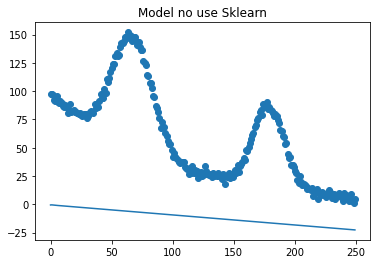

In [259]:
y_pred = model.predict(X)
plt.scatter(X, y)
plt.plot(X, y_pred)
plt.title("Model no use Sklearn")

## Use sklearn

In [218]:
import sklearn
from sklearn.neural_network import MLPRegressor

X = X.reshape((-1, 1))
y = y.reshape((-1,))

model = sklearn.neural_network.MLPRegressor(
                    solver='sgd',
                    hidden_layer_sizes=(5), 
                    random_state=1, 
                    max_iter=10000, 
                    verbose=True, 
                    learning_rate='constant',
                    learning_rate_init=0.1,
                    n_iter_no_change=200,
                    activation='relu',
                    tol=0.01,
                    batch_size=X.shape[0])

model.fit(X, y)
model.score(X, y)

Iteration 1, loss = 0.54923893
Iteration 2, loss = 0.32586918
Iteration 3, loss = 0.27752541
Iteration 4, loss = 0.19966998
Iteration 5, loss = 0.12254446
Iteration 6, loss = 0.06712144
Iteration 7, loss = 0.04064539
Iteration 8, loss = 0.03858993
Iteration 9, loss = 0.05012626
Iteration 10, loss = 0.06396252
Iteration 11, loss = 0.07236448
Iteration 12, loss = 0.07256278
Iteration 13, loss = 0.06594583
Iteration 14, loss = 0.05608079
Iteration 15, loss = 0.04665968
Iteration 16, loss = 0.04011715
Iteration 17, loss = 0.03717379
Iteration 18, loss = 0.03714600
Iteration 19, loss = 0.03864853
Iteration 20, loss = 0.04030639
Iteration 21, loss = 0.04122161
Iteration 22, loss = 0.04111410
Iteration 23, loss = 0.04019873
Iteration 24, loss = 0.03893215
Iteration 25, loss = 0.03776293
Iteration 26, loss = 0.03697166
Iteration 27, loss = 0.03662603
Iteration 28, loss = 0.03662709
Iteration 29, loss = 0.03679883
Iteration 30, loss = 0.03697461
Iteration 31, loss = 0.03705088
Iteration 32, los

0.06895412521656707

Text(0.5, 1.0, 'Model use Sklearn')

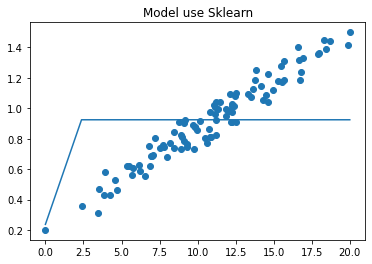

In [219]:
y_pred = model.predict(X)
plt.scatter(X, y)
plt.plot(X, y_pred)
plt.title("Model use Sklearn")

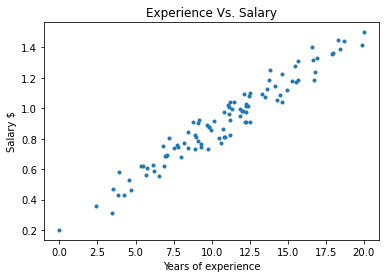

In [188]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt #for plotting

X, y, coef = datasets.make_regression(n_samples=100,#number of samples
                                      n_features=1,#number of features
                                      n_informative=1,#number of useful features 
                                      noise=10,#bias and standard deviation of the guassian noise
                                      coef=True,#true coefficient used to generated the data
                                      random_state=0) #set for same data points for each run

# Scale feature x (years of experience) to range 0..20
X = np.interp(x, (x.min(), x.max()), (0, 20))

# Scale target y (salary) to range 20000..150000 
y = np.interp(y, (y.min(), y.max()), (0.2, 1.5))

plt.ion() #interactive plot on
plt.plot(x,y,'.',label='training data')
plt.xlabel('Years of experience');plt.ylabel('Salary $')
plt.title('Experience Vs. Salary')

X = X.ravel()
sort_id = np.argsort(X)
X = X[sort_id]
y = y[sort_id]